In [1]:
import math
import numpy as np
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from plot_util import plot_history

Using TensorFlow backend.


In [0]:
TRAIN_DIR = './data/dogs-vs-cats-small/train'
VAL_DIR = './data/dogs-vs-cats-small/validation'
BATCH_SIZE = 20

In [3]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

def extract_feature(data_dir, num_sample):
    features = np.zeros((num_sample, 4 , 4, 512))
    labels = np.zeros((num_sample))
    data_iter = data_gen.flow_from_directory(
        data_dir, target_size=(150, 150), batch_size=BATCH_SIZE, class_mode='binary')
    num_batch = math.ceil(num_sample / BATCH_SIZE)
    print('Extracting {} batches.'.format(num_batch))
    for i in range(num_batch):
        batch_input, batch_label = next(data_iter)
        batch_features = conv_base.predict(batch_input)
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = batch_features
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = batch_label
    return features, labels

In [6]:
train_features, train_labels = extract_feature(TRAIN_DIR, 2000)
val_features, val_labels = extract_feature(VAL_DIR, 1000)
test_features, test_labels = extract_feature(VAL_DIR, 1000)
print("train_features.shape = {}\nval_features.shape = {}\ntest_features.shape = {}"
      .format(train_features.shape, val_features.shape, test_features.shape))

Found 2000 images belonging to 2 classes.
Extracting 100 batches.
Found 1000 images belonging to 2 classes.
Extracting 50 batches.
Found 1000 images belonging to 2 classes.
Extracting 50 batches.
train_features.shape = (2000, 4, 4, 512)
val_features.shape = (1000, 4, 4, 512)
test_features.shape = (1000, 4, 4, 512)


In [7]:
def flatten(features):
    n, h, w, c = features.shape
    return features.reshape(n, h * w * c)

train_features_flatten = flatten(train_features)
val_features_flatten = flatten(val_features)
test_features_flatten = flatten(test_features)
print("train_features_flatten.shape = {}\nval_features_flatten.shape = {}\ntest_features_flatten.shape = {}"
      .format(train_features_flatten.shape, val_features_flatten.shape, test_features_flatten.shape))

train_features_flatten.shape = (2000, 8192)
val_features_flatten.shape = (1000, 8192)
test_features_flatten.shape = (1000, 8192)


In [8]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=8192))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
history = model.fit(train_features_flatten, train_labels, epochs=30, batch_size=20,
                    validation_data=(val_features_flatten, val_labels), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
 - 1s - loss: 3.0675 - acc: 0.7385 - val_loss: 0.7750 - val_acc: 0.9110
Epoch 2/30
 - 1s - loss: 1.4621 - acc: 0.8660 - val_loss: 0.5637 - val_acc: 0.9370
Epoch 3/30
 - 1s - loss: 1.1981 - acc: 0.8920 - val_loss: 0.5339 - val_acc: 0.9430
Epoch 4/30
 - 1s - loss: 0.7671 - acc: 0.9260 - val_loss: 0.4140 - val_acc: 0.9570
Epoch 5/30
 - 1s - loss: 0.7502 - acc: 0.9330 - val_loss: 0.4287 - val_acc: 0.9500
Epoch 6/30
 - 1s - loss: 0.6883 - acc: 0.9370 - val_loss: 0.3944 - val_acc: 0.9560
Epoch 7/30
 - 1s - loss: 0.5603 - acc: 0.9490 - val_loss: 0.3656 - val_acc: 0.9590
Epoch 8/30
 - 1s - loss: 0.4245 - acc: 0.9595 - val_loss: 0.3470 - val_acc: 0.9590
Epoch 9/30
 - 1s - loss: 0.4303 - acc: 0.9570 - val_loss: 0.3252 - val_acc: 0.9650
Epoch 10/30
 - 1s - loss: 0.3629 - acc: 0.9655 - val_loss: 0.3234 - val_acc: 0.9630
Epoch 11/30
 - 1s - loss: 0.3198 - acc: 0.9655 - val_loss: 0.3388 - val_a

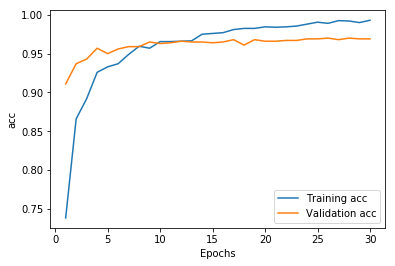

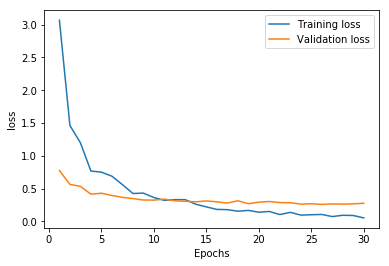

In [10]:
plot_history(history, metrics=('acc', 'loss'))